# Introduction

The goal of this competition is to predict 1 year of sales for 3 different items at 2 different stores in 3 different countries using the last 4 years.
The evalutation is based on SMAPE:

SMAPE = $\frac{100\%}{n}\displaystyle\sum_{t=1}^{n} \frac{|Ft-At|}{(|At|+|Ft|)/2}$

My goals are: learning something more on GAM models (Generalized additive model) and achieving a good score using them.
In my first attempt using GAM for time series:

https://www.kaggle.com/code/mr0024/store-forecasting-using-gam

I tried pygam from:

https://pygam.readthedocs.io/en/latest/

After searching on web I discovered that R provides one of the best package to build GAM model: MGCV.

https://www.rdocumentation.org/packages/mgcv/versions/1.8-40/topics/gam

So this time I will use it and, as I don't know R but I would like to try MGCV, I will pass through rpy2, which allows to use R packages directly in python code:

https://rpy2.github.io/doc/latest/html/introduction.html

# Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [2]:
import warnings

from scipy.stats import zscore
      
from sklearn.model_selection import train_test_split

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [4]:
warnings.filterwarnings('ignore')

In [5]:
sns.set_theme()

#### Installing rpy2

In [6]:
import subprocess

In [7]:
subprocess.run('conda install -c conda-forge r-base', shell=True)

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - r-base


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _r-mutex-1.0.1             |      anacondar_1           3 KB  conda-forge
    libgcc-7.2.0               |       h69d50b8_2         304 KB  conda-forge
    openssl-1.1.1q             |       h166bdaf_0         2.1 MB  conda-forge
    r-base-3.2.2               |                0        18.9 MB
    ------------------------------------------------------------
                                           Total:        21.3 MB

The following NEW packages will be INSTALLED:

  _r-mutex           conda-forge/noarch::_r-mutex-1.0.1-anacondar_1
  libgcc             conda-forge/linux-64::libgcc-7.2.0-h69d50b8_2
  r-base             pkgs/r/linux-64::r-base-3.2.2-0

The following packages will be UPDATED:

  openssl   

CompletedProcess(args='conda install -c conda-forge r-base', returncode=0)

In [8]:
subprocess.run('conda install -n base conda-forge::mamba', shell=True,
              stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

CompletedProcess(args='conda install -n base conda-forge::mamba', returncode=0)

In [9]:
subprocess.run('mamba install -n base -c r rpy2', shell=True, stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)

CompletedProcess(args='mamba install -n base -c r rpy2', returncode=0)

#### Loading base libreries

In [10]:
import rpy2

In [11]:
import rpy2.rinterface as rinterface
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector, FloatVector, StrVector
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [12]:
base = importr('base')
utils = importr('utils')
r_stats = importr('stats')

#### Installing MGCV

In [13]:
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f8820d03d20> [RTYPES.NILSXP]

In [14]:
utils.install_packages(StrVector(['mgcv']))

* installing *source* package ‘lattice’ ...
** package ‘lattice’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1630154298835/work=/usr/local/src/conda/r-base-4.1.1 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c init.c -o init.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1630154298835/work=/usr/local/src/conda/r-base-4.1.1 -

installing to /opt/conda/lib/R/library/00LOCK-lattice/00new/lattice/libs
** R
** data
*** moving datasets to lazyload DB
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (lattice)
* installing *source* package ‘nlme’ ...
** package ‘nlme’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


x86_64-conda-linux-gnu-gfortran -fno-optimize-sibling-calls  -fpic  -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1630154298835/work=/usr/local/src/conda/r-base-4.1.1 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c chol.f -o chol.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib  -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1630154298835/work=/usr/local/src/conda/r-base-4.1.1 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c corStruct.c -o corStruct.o
x86_

installing to /opt/conda/lib/R/library/00LOCK-nlme/00new/nlme/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (nlme)
* installing *source* package ‘Matrix’ ...
** package ‘Matrix’ successfully unpacked and MD5 sums checked
** using staged installation
** libs


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1630154298835/work=/usr/local/src/conda/r-base-4.1.1 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c CHMfactor.c -o CHMfactor.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DNTIMER -I./SuiteSparse_config -DUSE_FC_LEN_T  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/co

installing to /opt/conda/lib/R/library/00LOCK-Matrix/00new/Matrix/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Matrix)
* installing *source* package ‘mgcv’ ...
** package ‘mgcv’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
mat.c: In function 'dump_mat':
mat.c:90:3: warning: ignoring return value of 'fwrite', declared with attribute warn_unused_result [-Wunused-result]
   90 |   fwrite(r,sizeof(int),1,mf); fwrite(c,sizeof(int),1,mf);
      |   ^~~~~~~~~~~~~~~~~~~~~~~~~~
mat.c:90:31: warning: ignoring return value of 'fwrite', declared with attribute

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f8820d03d20> [RTYPES.NILSXP]

In [15]:
mgcv = importr('mgcv')

In [16]:
pandas2ri.activate()

# Importing the dataset

In [17]:
orig_train = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/train.csv", parse_dates=['date'])

In [18]:
orig_test = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/test.csv", parse_dates=['date'])

In [19]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    26298 non-null  int64         
 1   date      26298 non-null  datetime64[ns]
 2   country   26298 non-null  object        
 3   store     26298 non-null  object        
 4   product   26298 non-null  object        
 5   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.2+ MB


In [20]:
orig_train.sample(10)

row_id       date  country       store         product  num_sold
7358     7358 2016-02-13   Sweden  KaggleMart  Kaggle Sticker       121
16354   16354 2017-06-27   Norway  KaggleRama      Kaggle Hat       975
3873     3873 2015-08-04  Finland  KaggleRama      Kaggle Mug       267
1451     1451 2015-03-22   Norway  KaggleRama  Kaggle Sticker       328
23008   23008 2018-07-02  Finland  KaggleRama      Kaggle Hat       665
6502     6502 2015-12-28  Finland  KaggleRama      Kaggle Hat      1051
17267   17267 2017-08-17  Finland  KaggleRama  Kaggle Sticker       171
5915     5915 2015-11-25   Norway  KaggleRama  Kaggle Sticker       243
761       761 2015-02-12  Finland  KaggleRama  Kaggle Sticker       140
12851   12851 2016-12-14   Sweden  KaggleRama  Kaggle Sticker       178

In [21]:
orig_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570 entries, 0 to 6569
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   row_id   6570 non-null   int64         
 1   date     6570 non-null   datetime64[ns]
 2   country  6570 non-null   object        
 3   store    6570 non-null   object        
 4   product  6570 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 256.8+ KB


In [22]:
orig_test.sample(10)

row_id       date  country       store     product
1159   27457 2019-03-06   Norway  KaggleMart  Kaggle Hat
1479   27777 2019-03-24  Finland  KaggleRama  Kaggle Mug
5650   31948 2019-11-10   Sweden  KaggleRama  Kaggle Hat
984    27282 2019-02-24   Sweden  KaggleMart  Kaggle Mug
5467   31765 2019-10-31   Sweden  KaggleMart  Kaggle Hat
261    26559 2019-01-15   Norway  KaggleRama  Kaggle Mug
5775   32073 2019-11-17   Sweden  KaggleRama  Kaggle Mug
5008   31306 2019-10-06  Finland  KaggleRama  Kaggle Hat
4996   31294 2019-10-05   Norway  KaggleRama  Kaggle Hat
4245   30543 2019-08-24   Sweden  KaggleRama  Kaggle Mug

# Creating main features

In [23]:
def add_features (orig_df):
    
    df = orig_df.copy()
    
    df = df.set_index('date').sort_index()
        
    # Time features
    df['year'] = df.index.year.astype('int')
    df['month'] = df.index.month.astype('int')
    df['day'] = df.index.day.astype('int')
    df['dayofweek'] = df.index.day_of_week.astype('int')
    df['dayofyear'] = df.index.day_of_year.astype('int')
    df['trend'] = df.index.map(pd.Timestamp.timestamp)

    return df

In [24]:
train = add_features(orig_train)
test = add_features(orig_test)

In [25]:
test.insert(4, "num_sold", np.nan)

In [26]:
df = pd.concat([train, test], axis=0).sort_index()

# Setting main dates

In [27]:
date = {}
date['date_start_train'] = '2015-01-01'
date['date_end_train'] = '2018-12-31'
date['date_start_test'] = '2019-01-01'
date['date_end_test'] = '2019-12-31'
date['date_start_fore'] = '2015-01-01'

diff_train = (pd.Timestamp(date['date_end_train']) - pd.Timestamp(date['date_start_fore'])).days
diff_test = (pd.Timestamp(date['date_end_test']) - pd.Timestamp(date['date_start_fore'])).days

# Time serie plots

#### Finland - KaggleMart

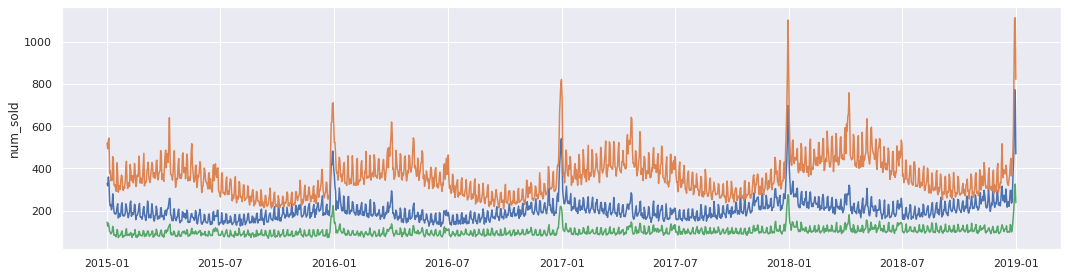

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

sns.lineplot(x=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Mug'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Hat'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Sticker'")['num_sold'])
    
fig.tight_layout()

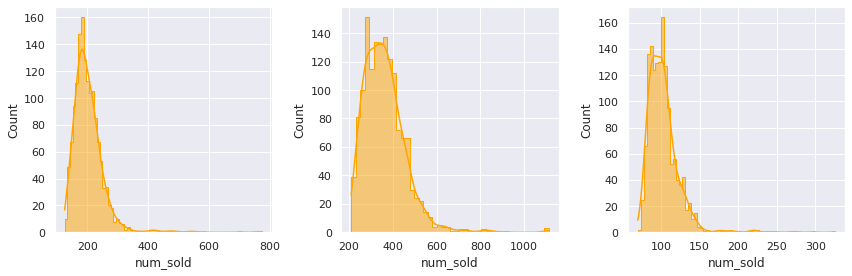

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(ax=axes[0], x=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Mug'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[1], x=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Hat'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[2], x=orig_train.query("country=='Finland' and store=='KaggleMart' and product=='Kaggle Sticker'")['num_sold'], element="step", color="orange", kde=True)

fig.tight_layout()

#### Finland - KaggleRama

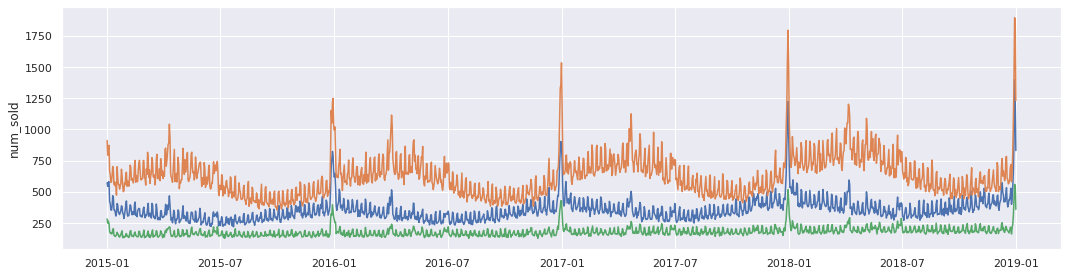

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

sns.lineplot(x=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Mug'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Hat'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Sticker'")['num_sold'])
    
fig.tight_layout()

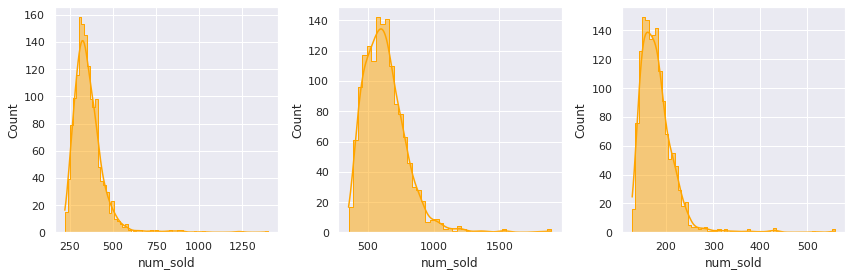

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(ax=axes[0], x=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Mug'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[1], x=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Hat'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[2], x=orig_train.query("country=='Finland' and store=='KaggleRama' and product=='Kaggle Sticker'")['num_sold'], element="step", color="orange", kde=True)

fig.tight_layout()

#### Norway - KaggleMart

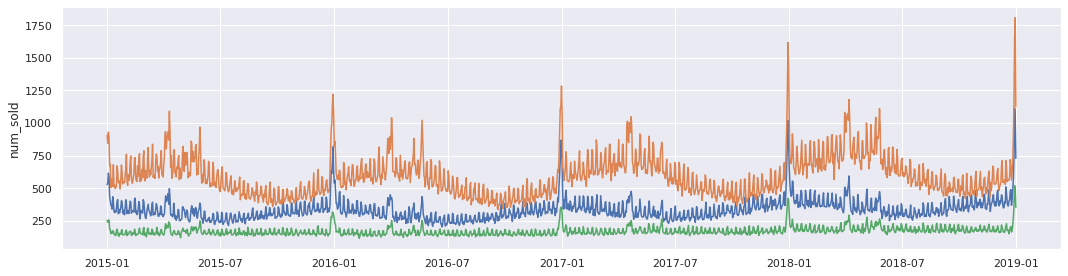

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

sns.lineplot(x=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Mug'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Hat'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Sticker'")['num_sold'])
    
fig.tight_layout()

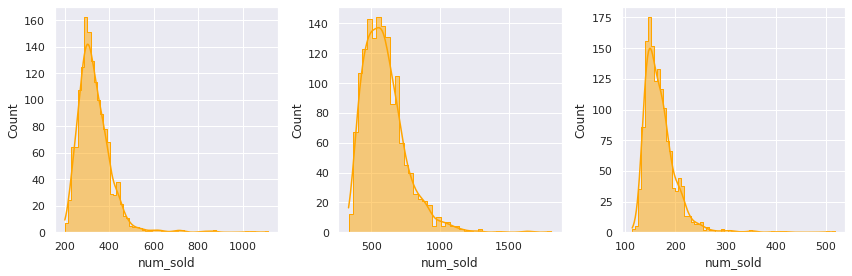

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(ax=axes[0], x=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Mug'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[1], x=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Hat'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[2], x=orig_train.query("country=='Norway' and store=='KaggleMart' and product=='Kaggle Sticker'")['num_sold'], element="step", color="orange", kde=True)

fig.tight_layout()

#### Norway - KaggleRama

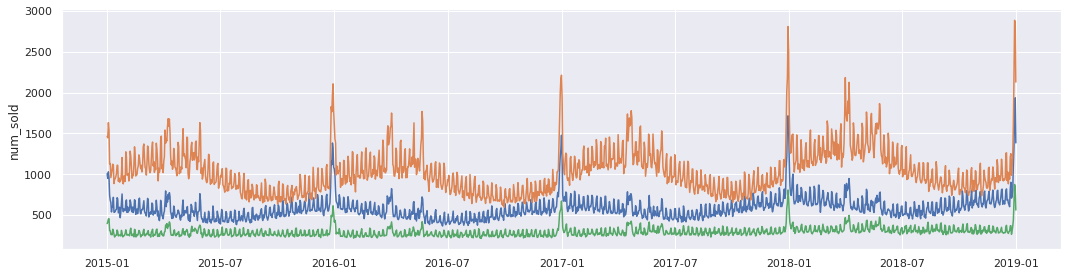

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

sns.lineplot(x=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Mug'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Hat'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Sticker'")['num_sold'])
    
fig.tight_layout()

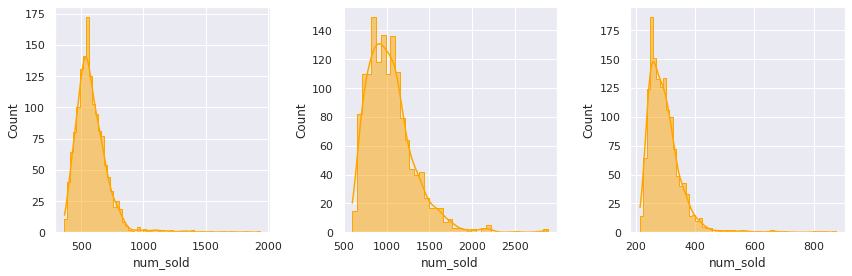

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(ax=axes[0], x=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Mug'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[1], x=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Hat'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[2], x=orig_train.query("country=='Norway' and store=='KaggleRama' and product=='Kaggle Sticker'")['num_sold'], element="step", color="orange", kde=True)

fig.tight_layout()

#### Sweden - KaggleMart

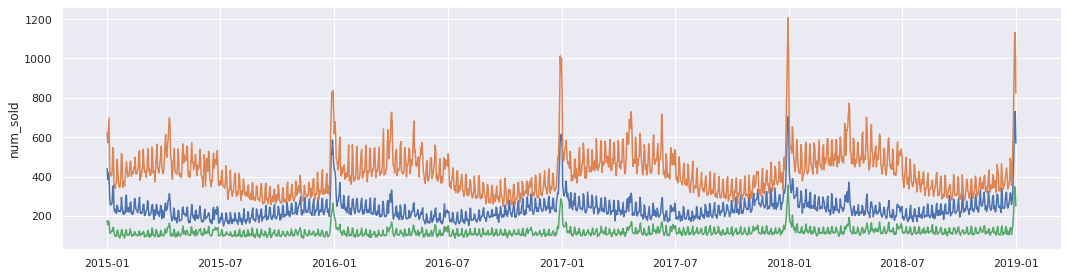

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

sns.lineplot(x=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Mug'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Hat'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Sticker'")['num_sold'])
    
fig.tight_layout()

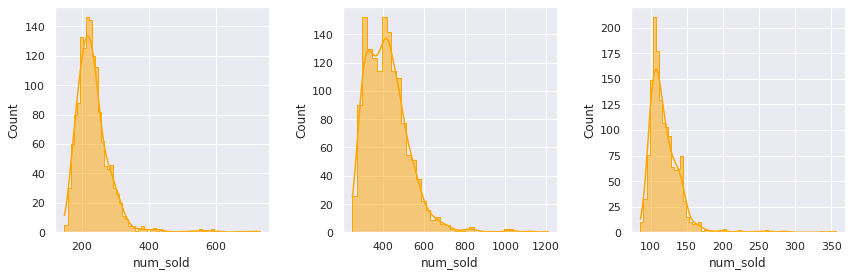

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(ax=axes[0], x=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Mug'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[1], x=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Hat'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[2], x=orig_train.query("country=='Sweden' and store=='KaggleMart' and product=='Kaggle Sticker'")['num_sold'], element="step", color="orange", kde=True)

fig.tight_layout()

#### Sweden - KaggleRama

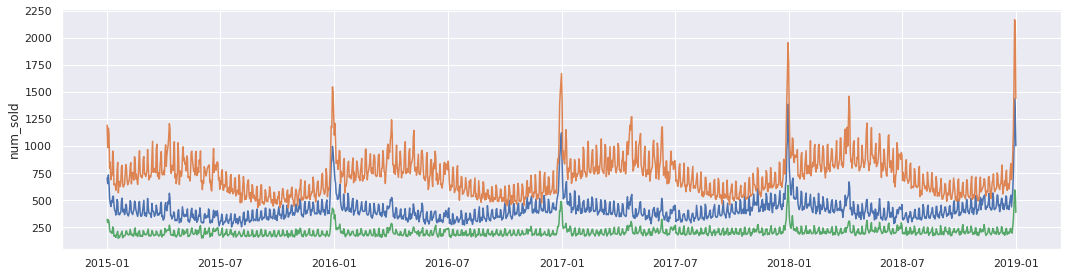

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

sns.lineplot(x=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Mug'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Hat'")['num_sold'])
sns.lineplot(x=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Mug'").date.values, y=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Sticker'")['num_sold'])
    
fig.tight_layout()

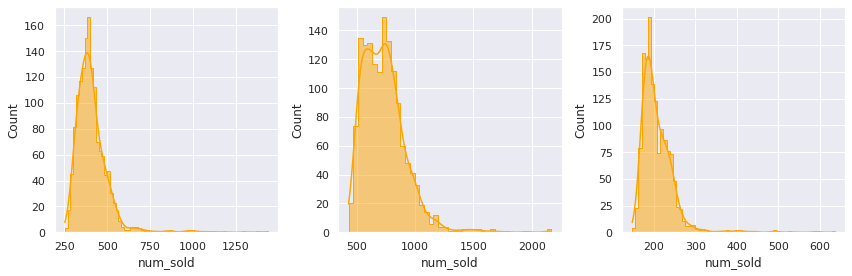

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(ax=axes[0], x=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Mug'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[1], x=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Hat'")['num_sold'], element="step", color="orange", kde=True)
sns.histplot(ax=axes[2], x=orig_train.query("country=='Sweden' and store=='KaggleRama' and product=='Kaggle Sticker'")['num_sold'], element="step", color="orange", kde=True)

fig.tight_layout()

# The model

The plots show regular patterns with peaks in conjunction with the event periods. 
So I will try to catch the main patterns using: trend feature or year as a trend, day of the year for yearly seasonality and day of week for weekly seasonality.
To manage the event periods instead, I will create dummy features for each event, distinguishing between events fixed on day of the month and events fixed on day of the week.
I will use by-interaction between these features and respectively day of month and day of week, in order to have a different smooth function over each period.

A GAM model is like:

$g(E(Y)) = \beta_0 + f_1(x_1) + f_2(x_2) +...+ f_n(x_n)$

where:
- g is the link function;

- $f_i$ are functions built using penalized B splines;

- the $x_i$ are the features chosen.

So in this case the model will be something as:

$g(E(sales)) = trend + f_1(day\_of\_year) + f_2(day\_of\_week) + \displaystyle\sum_{i=1}^{n}f_i(day,by=event_i) + \displaystyle\sum_{j=1}^{m}f_j(day\_of\_week,by=event_j)$

#### The steps I followed: 

- I built a simple function working on each country, which iterates over each store and product providing the measure of SMAPE on the training and test periods, and some plots.

- At first I ran a model with only year, day of week and day of the year using a quasipoisson distribution family, so I could check how the model behaved. The quasipoisson distribution family allows to avoid the restriction of Poisson on the variance and uses the logarithm as a link function.

- After running the model, I used high residuals to locate the likely event dates.

- As the event periods were different between the different countries, I had to create a model for each country.

- I applied the model described at the beginning and I tried to submit the results: the score was bad. This because I predicted the new year without considering a possible change of the growth, indeed checking the gross domestic product of the three countries, the growth didn't go on in 2019:

In [40]:
def growth_func(orig_df):
    df = orig_df.copy()
    
    grw_df = df.groupby(by=['country','year']).num_sold.sum().reset_index()
    
    grw_df['lag_num_sold'] = grw_df.num_sold.shift(1, fill_value=0)
    grw_df['num_sold_grw'] = round(grw_df['num_sold'] / grw_df['lag_num_sold'],3)
    
    grw_df.loc[grw_df.country=='Finland', ['gdp']] = grw_df.loc[(grw_df.country=='Finland'),'year'].apply(lambda x: 234.44 if x==2015 else(240.608 if x==2016 else(255.017 if x==2017 else (275.58 if x==2018 else 268.782)))) 
    grw_df.loc[grw_df.country=='Norway', ['gdp']] = grw_df.loc[(grw_df.country=='Norway'),'year'].apply(lambda x: 385.802 if x==2015 else(368.827 if x==2016 else(398.394 if x==2017 else (437 if x==2018 else 405.51))))
    grw_df.loc[grw_df.country=='Sweden', ['gdp']] = grw_df.loc[(grw_df.country=='Sweden'),'year'].apply(lambda x: 505.104 if x==2015 else(515.655 if x==2016 else(541.019 if x==2017 else (555.455 if x==2018 else 533.88))))
    
    grw_df['lag_gdp'] = grw_df.gdp.shift(1, fill_value=0)
    grw_df['gdp_grw'] = round(grw_df['gdp'] / grw_df['lag_gdp'],4)
    
    grw_df['sold'] = grw_df['num_sold'] / grw_df['gdp']
    grw_df['lag_sold'] = grw_df.sold.shift(1, fill_value=0)
    grw_df['raw_sold_grw'] = round(grw_df['sold'] / grw_df['lag_sold'],4)
    
    grw_df = grw_df.loc[grw_df.year!=2015,['country','year','num_sold_grw','gdp_grw','raw_sold_grw']]
    
    return grw_df

In [41]:
grw_df = growth_func(df)

In [42]:
grw_df

country  year  num_sold_grw  gdp_grw  raw_sold_grw
1   Finland  2016         1.042   1.0263        1.0157
2   Finland  2017         1.085   1.0599        1.0241
3   Finland  2018         1.087   1.0806        1.0055
4   Finland  2019         0.000   0.9753        0.0000
6    Norway  2016         0.965   0.9560        1.0091
7    Norway  2017         1.097   1.0802        1.0157
8    Norway  2018         1.101   1.0969        1.0038
9    Norway  2019         0.000   0.9279        0.0000
11   Sweden  2016         1.028   1.0209        1.0072
12   Sweden  2017         1.061   1.0492        1.0109
13   Sweden  2018         1.023   1.0267        0.9963
14   Sweden  2019         0.000   0.9612        0.0000

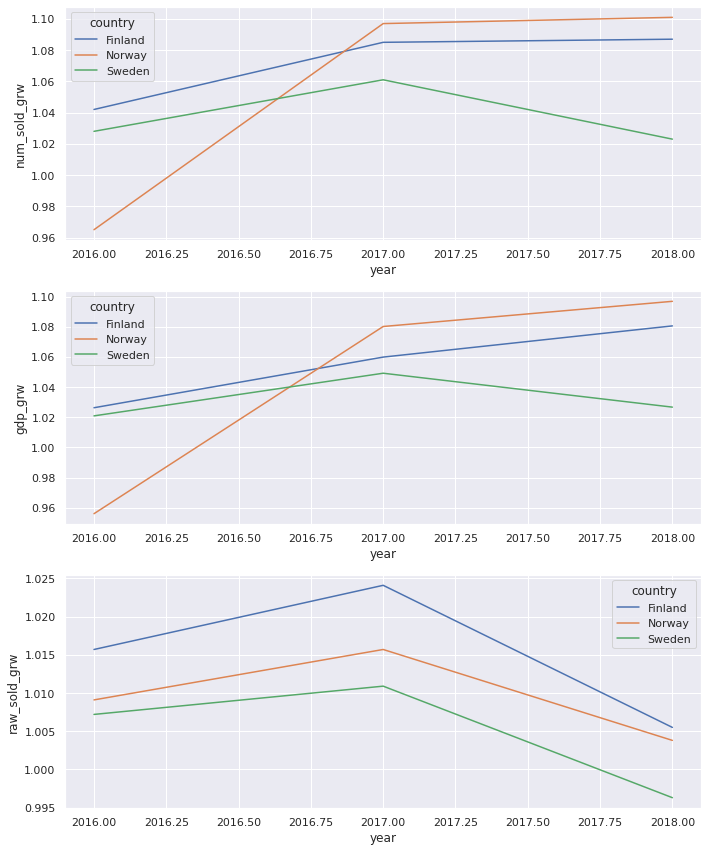

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
sns.lineplot(ax=axes[0], x=grw_df.loc[grw_df.year!=2019].year, y=grw_df.num_sold_grw, hue=grw_df.country)
sns.lineplot(ax=axes[1], x=grw_df.loc[grw_df.year!=2019].year, y=grw_df.gdp_grw, hue=grw_df.country)
sns.lineplot(ax=axes[2], x=grw_df.loc[grw_df.year!=2019].year, y=grw_df.raw_sold_grw, hue=grw_df.country)
fig.tight_layout()

- I decided to remove the "effect" of GDP dividing num_sold by GDP and I applied a smooth function on the trend instead of only using a linear trend. 

- In order to give more weight to the recent years and to better catch the change of the growth, I decided to apply an exponentially weighted cost function to the model with a strong penalty on the past years.

- Eventually, searching on web, I found I missed the days after the Costitution Day in Norway and the ones after the National Day in Sweden, so I added them. As they overlapped the days after Pentecost/Ascension over some years, they drove the model to bad fit those periods.

#### Creating SMAPE evaluation

In [44]:
def smape(A, F):
    smape = 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return smape

#### Creating a function to divide training and test sample

In [45]:
def split_func (orig_df, X, y, end_date, test_size):
    
    idx_train, idx_test = train_test_split(orig_df.index, test_size=test_size, shuffle=False)
    X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
    y_train, y_test = y.loc[idx_train], y.loc[idx_test]
    
    return X_train, y_train, X_test, y_test

#### Creating events

In [46]:
def event_func (orig_df, country):
    
    df = orig_df.copy()
    
    # Fixed events on day of month
    df['ch'] = 0  
    df['ny'] = 0 
    df['fm'] = 0
    df['nat'] = 0 
    # Fixed events on day of week
    df['alls'] = 0 
    df['feaster'] = 0 
    df['seaster'] = 0 
    df['mids'] = 0 
    df['event'] = 0
    df['asc'] = 0  
    # GDP
    df['gdp'] = 0   

    if country == 'Finland':
        df = df.loc[df.country=='Finland']
    
        df['gdp'] = df.year.apply(lambda x: 234.44 if x==2015 else(240.608 if x==2016 else(255.017 if x==2017 else
                                  (275.58 if x==2018 else 268.782)))) 
        # Fixed events on day of month
        # Independence
        df.loc[(df.index.month==12) & (df.index.day ==9),'ch'] = 1  
        df.loc[(df.index.month==12) & (df.index.day ==10),'ch'] = 1  
        df.loc[(df.index.month==12) & (df.index.day ==11),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==12),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==13),'ch'] = 1
        # Christmas
        df.loc[(df.index.month==12) & (df.index.day ==24),'ch'] = 1   
        df.loc[(df.index.month==12) & (df.index.day ==25),'ch'] = 1   
        df.loc[(df.index.month==12) & (df.index.day ==26),'ch'] = 1   
        df.loc[(df.index.month==12) & (df.index.day ==27),'ch'] = 1 
        df.loc[(df.index.month==12) & (df.index.day ==28),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==29),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==30),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==31),'ch'] = 1
        # New Year
        df.loc[(df.index.month==1) & (df.index.day ==1),'ny'] = 1
        df.loc[(df.index.month==1) & (df.index.day ==2),'ny'] = 1  
        df.loc[(df.index.month==1) & (df.index.day ==3),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==4),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==5),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==6),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==7),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==8),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==9),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==10),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==11),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==12),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==13),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==14),'ny'] = 1
        df.loc[(df.index.month==1) & (df.index.day ==15),'ny'] = 1 
        # 1 may  
        df.loc[(df.index.month==5) & (df.index.day ==2),'fm'] = 1 
        df.loc[(df.index.month==5) & (df.index.day ==3),'fm'] = 1  
        df.loc[(df.index.month==5) & (df.index.day ==4),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==5),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==6),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==7),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==8),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==9),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==10),'fm'] = 1
        # Fixed events on day of week
        # Easter 2019-04-22
        df.loc[(df.index>='2015-04-05') & (df.index<='2015-04-11'),'feaster'] = 1
        df.loc[(df.index>='2016-03-27') & (df.index<='2016-04-02'),'feaster'] = 1
        df.loc[(df.index>='2017-04-16') & (df.index<='2017-04-22'),'feaster'] = 1
        df.loc[(df.index>='2018-04-01') & (df.index<='2018-04-07'),'feaster'] = 1
        df.loc[(df.index>='2019-04-21') & (df.index<='2019-04-27'),'feaster'] = 1
        
        df.loc[(df.index>='2015-04-12') & (df.index<='2015-04-15'),'seaster'] = 1
        df.loc[(df.index>='2016-04-03') & (df.index<='2016-04-06'),'seaster'] = 1
        df.loc[(df.index>='2017-04-23') & (df.index<='2017-04-26'),'seaster'] = 1
        df.loc[(df.index>='2018-04-08') & (df.index<='2018-04-11'),'seaster'] = 1
        df.loc[(df.index>='2019-04-28') & (df.index<='2019-05-01'),'seaster'] = 1
        # Pentecost 2019-06-09 sun   
        df.loc[(df.index>='2015-05-25') & (df.index<='2015-06-01'),'event'] = 1
        df.loc[(df.index>='2016-05-16') & (df.index<='2016-05-23'),'event'] = 1
        df.loc[(df.index>='2017-06-05') & (df.index<='2017-06-12'),'event'] = 1
        df.loc[(df.index>='2018-05-21') & (df.index<='2018-05-28'),'event'] = 1
        df.loc[(df.index>='2019-06-10') & (df.index<='2019-06-17'),'event'] = 1
        # Ascension 2019-05-30 tue
        df.loc[(df.index>='2015-05-15') & (df.index<='2015-05-22'),'asc'] = 1
        df.loc[(df.index>='2016-05-06') & (df.index<='2016-05-13'),'asc'] = 1
        df.loc[(df.index>='2017-05-26') & (df.index<='2017-06-02'),'asc'] = 1
        df.loc[(df.index>='2018-05-11') & (df.index<='2018-05-18'),'asc'] = 1
        df.loc[(df.index>='2019-05-31') & (df.index<='2019-06-07'),'asc'] = 1
        # Midsummer 2019-06-22 sat     
        df.loc[(df.index>='2015-06-20') & (df.index<='2015-06-27'),'mids'] = 1
        df.loc[(df.index>='2016-06-25') & (df.index<='2016-07-02'),'mids'] = 1
        df.loc[(df.index>='2017-06-24') & (df.index<='2017-07-01'),'mids'] = 1
        df.loc[(df.index>='2018-06-23') & (df.index<='2018-06-30'),'mids'] = 1
        df.loc[(df.index>='2019-06-22') & (df.index<='2019-06-29'),'mids'] = 1
        # All Saints 2019-11-02 sat
        df.loc[(df.index>='2015-11-01') & (df.index<='2015-11-07'),'alls'] = 1
        df.loc[(df.index>='2016-11-06') & (df.index<='2016-11-12'),'alls'] = 1
        df.loc[(df.index>='2017-11-05') & (df.index<='2017-11-11'),'alls'] = 1
        df.loc[(df.index>='2018-11-04') & (df.index<='2018-11-10'),'alls'] = 1
        df.loc[(df.index>='2019-11-03') & (df.index<='2019-11-09'),'alls'] = 1
  
    elif country == 'Norway':
        df = df.loc[df.country=='Norway']
        
        df['gdp'] = df.year.apply(lambda x: 385.802 if x==2015 else(368.827 if x==2016 else(398.394 if x==2017 else
                                  (437 if x==2018 else 405.51))))
        # Fixed events on day of month
        # Christmas 
        df.loc[(df.index.month==12) & (df.index.day ==24),'ch'] = 1  
        df.loc[(df.index.month==12) & (df.index.day ==25),'ch'] = 1  
        df.loc[(df.index.month==12) & (df.index.day ==26),'ch'] = 1  
        df.loc[(df.index.month==12) & (df.index.day ==27),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==28),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==29),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==30),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==31),'ch'] = 1
        # New Year
        df.loc[(df.index.month==1) & (df.index.day ==1),'ny'] = 1
        df.loc[(df.index.month==1) & (df.index.day ==2),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==3),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==4),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==5),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==6),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==7),'ny'] = 1 
        # 1 may  
        df.loc[(df.index.month==5) & (df.index.day ==2),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==3),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==4),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==5),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==6),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==7),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==8),'fm'] = 1
        # Constitution
        df.loc[(df.index.month==5) & (df.index.day ==17),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==18),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==19),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==20),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==21),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==22),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==23),'fm'] = 1
        # Fixed events on day of week
        # Easter
        df.loc[(df.index>='2015-04-04') & (df.index<='2015-04-10'),'feaster'] = 1
        df.loc[(df.index>='2016-03-26') & (df.index<='2016-04-01'),'feaster'] = 1
        df.loc[(df.index>='2017-04-15') & (df.index<='2017-04-21'),'feaster'] = 1
        df.loc[(df.index>='2018-03-31') & (df.index<='2018-04-06'),'feaster'] = 1
        df.loc[(df.index>='2019-04-20') & (df.index<='2019-04-26'),'feaster'] = 1
        
        df.loc[(df.index>='2015-04-11') & (df.index<='2015-04-15'),'seaster'] = 1
        df.loc[(df.index>='2016-04-02') & (df.index<='2016-04-06'),'seaster'] = 1
        df.loc[(df.index>='2017-04-22') & (df.index<='2017-04-26'),'seaster'] = 1
        df.loc[(df.index>='2018-04-07') & (df.index<='2018-04-11'),'seaster'] = 1
        df.loc[(df.index>='2019-04-27') & (df.index<='2019-05-01'),'seaster'] = 1
        # Pentecost 2019-06-09 sun        
        df.loc[(df.index>='2015-05-26') & (df.index<='2015-06-02'),'event'] = 1
        df.loc[(df.index>='2016-05-17') & (df.index<='2016-05-24'),'event'] = 1
        df.loc[(df.index>='2017-06-06') & (df.index<='2017-06-13'),'event'] = 1
        df.loc[(df.index>='2018-05-22') & (df.index<='2018-05-29'),'event'] = 1
        df.loc[(df.index>='2019-06-11') & (df.index<='2019-06-18'),'event'] = 1
        # Ascension 2019-05-30 thu      
        df.loc[(df.index>='2015-05-15') & (df.index<='2015-05-22'),'asc'] = 1
        df.loc[(df.index>='2016-05-06') & (df.index<='2016-05-13'),'asc'] = 1
        df.loc[(df.index>='2017-05-26') & (df.index<='2017-06-02'),'asc'] = 1
        df.loc[(df.index>='2018-05-11') & (df.index<='2018-05-18'),'asc'] = 1
        df.loc[(df.index>='2019-05-31') & (df.index<='2019-06-07'),'asc'] = 1 

    elif country == 'Sweden':
        df = df.loc[df.country=='Sweden']
        
        df['gdp'] = df.year.apply(lambda x: 505.104 if x==2015 else(515.655 if x==2016 else(541.019 if x==2017 else
                                  (555.455 if x==2018 else 533.88))))         
        # Fixed events on day of month
        # Christmas
        df.loc[(df.index.month==12) & (df.index.day ==24),'ch'] = 1  
        df.loc[(df.index.month==12) & (df.index.day ==25),'ch'] = 1  
        df.loc[(df.index.month==12) & (df.index.day ==26),'ch'] = 1  
        df.loc[(df.index.month==12) & (df.index.day ==27),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==28),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==29),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==30),'ch'] = 1
        df.loc[(df.index.month==12) & (df.index.day ==31),'ch'] = 1
        # New Year
        df.loc[(df.index.month==1) & (df.index.day ==1),'ny'] = 1
        df.loc[(df.index.month==1) & (df.index.day ==2),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==3),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==4),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==5),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==6),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==7),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==8),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==9),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==10),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==11),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==12),'ny'] = 1 
        df.loc[(df.index.month==1) & (df.index.day ==13),'ny'] = 1
        df.loc[(df.index.month==1) & (df.index.day ==14),'ny'] = 1
        # 1 may 
        df.loc[(df.index.month==5) & (df.index.day ==2),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==3),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==4),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==5),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==6),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==7),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==8),'fm'] = 1
        df.loc[(df.index.month==5) & (df.index.day ==9),'fm'] = 1
        # National Day
        df.loc[(df.index.month==6) & (df.index.day ==8),'nat'] = 1
        df.loc[(df.index.month==6) & (df.index.day ==9),'nat'] = 1
        df.loc[(df.index.month==6) & (df.index.day ==10),'nat'] = 1
        df.loc[(df.index.month==6) & (df.index.day ==11),'nat'] = 1
        df.loc[(df.index.month==6) & (df.index.day ==12),'nat'] = 1
        df.loc[(df.index.month==6) & (df.index.day ==13),'nat'] = 1
        # Fixed events on day of week
        # Easter 
        df.loc[(df.index>='2015-04-05') & (df.index<='2015-04-11'),'feaster'] = 1
        df.loc[(df.index>='2016-03-27') & (df.index<='2016-04-02'),'feaster'] = 1
        df.loc[(df.index>='2017-04-16') & (df.index<='2017-04-22'),'feaster'] = 1
        df.loc[(df.index>='2018-04-01') & (df.index<='2018-04-07'),'feaster'] = 1
        df.loc[(df.index>='2019-04-21') & (df.index<='2019-04-27'),'feaster'] = 1
        
        df.loc[(df.index>='2015-04-12') & (df.index<='2015-04-15'),'seaster'] = 1
        df.loc[(df.index>='2016-04-03') & (df.index<='2016-04-06'),'seaster'] = 1
        df.loc[(df.index>='2017-04-23') & (df.index<='2017-04-26'),'seaster'] = 1
        df.loc[(df.index>='2018-04-08') & (df.index<='2018-04-11'),'seaster'] = 1
        df.loc[(df.index>='2019-04-28') & (df.index<='2019-05-01'),'seaster'] = 1
        # Pentecost 2019-06-09 sun        
        df.loc[(df.index>='2015-05-25') & (df.index<='2015-06-01'),'event'] = 1
        df.loc[(df.index>='2016-05-16') & (df.index<='2016-05-23'),'event'] = 1
        df.loc[(df.index>='2017-06-05') & (df.index<='2017-06-12'),'event'] = 1
        df.loc[(df.index>='2018-05-21') & (df.index<='2018-05-28'),'event'] = 1
        df.loc[(df.index>='2019-06-10') & (df.index<='2019-06-17'),'event'] = 1
        # Ascension 2019-05-30 thu       
        df.loc[(df.index>='2015-05-16') & (df.index<='2015-05-21'),'asc'] = 1
        df.loc[(df.index>='2016-05-07') & (df.index<='2016-05-12'),'asc'] = 1
        df.loc[(df.index>='2017-05-27') & (df.index<='2017-06-01'),'asc'] = 1
        df.loc[(df.index>='2018-05-12') & (df.index<='2018-05-17'),'asc'] = 1
        df.loc[(df.index>='2019-06-01') & (df.index<='2019-06-06'),'asc'] = 1
        # Midsummer 2019-06-22 sat
        df.loc[(df.index>='2015-06-20') & (df.index<='2015-06-27'),'mids'] = 1
        df.loc[(df.index>='2016-06-25') & (df.index<='2016-07-02'),'mids'] = 1
        df.loc[(df.index>='2017-06-24') & (df.index<='2017-07-01'),'mids'] = 1
        df.loc[(df.index>='2018-06-23') & (df.index<='2018-06-30'),'mids'] = 1
        df.loc[(df.index>='2019-06-22') & (df.index<='2019-06-29'),'mids'] = 1
        # All Saints 2019-11-02 sat
        df.loc[(df.index>='2015-11-01') & (df.index<='2015-11-08'),'alls'] = 1
        df.loc[(df.index>='2016-11-06') & (df.index<='2016-11-13'),'alls'] = 1
        df.loc[(df.index>='2017-11-05') & (df.index<='2017-11-12'),'alls'] = 1
        df.loc[(df.index>='2018-11-04') & (df.index<='2018-11-11'),'alls'] = 1
        df.loc[(df.index>='2019-11-03') & (df.index<='2019-11-10'),'alls'] = 1

    return df

#### Performance function

In [47]:
def gam_func (orig_df, end_df, n, country):
    
    df = orig_df.loc[:end_df,:]

    # Creating events
    df = event_func(df, country)
    
    # Empty arrays
    if end_df <= date['date_end_train']:
        y_tr = np.empty((diff_train-n+1))
        y_te = np.empty((n))
        pred_train_y = np.empty((diff_train-n+1))
        pred_test_y = np.empty((n))
    else:
        y_tr = np.empty((diff_test-n+1))
        y_te = np.empty((n))
        pred_train_y = np.empty((diff_test-n+1))
        pred_test_y = np.empty((n))
    
    # Iterating over stores and products
    for i in df.store.unique():
        for j in df['product'].unique():
            y = df.loc[(df.store==i) & (df['product']==j),:].num_sold
            X = df.loc[(df.store==i) & (df['product']==j),:].drop(columns=['store', 'row_id', 'product','country'])
            
            # Removing GDP
            y = y/X.gdp
            X['num_sold'] = (X['num_sold'])/(X.gdp)
            
            X_train, y_train, X_test, y_test = split_func(y, X, y, end_df, n)
            
            # Exponentially weighted cost function
            weights = X_train.year.apply(lambda x: np.exp((-2/3)*(2018 - x)))
            
            # Converting python dataframe to R dataframe 
            X_train = ro.conversion.py2rpy(X_train)
            X_test = ro.conversion.py2rpy(X_test)
            
            # The model using MGCV and GAM
            # Norway model
            if country == 'Norway':
                        model = mgcv.gam(ro.Formula('num_sold ~ \
                                            s(dayofyear, bs="cc", k=11) \
                                            + s(dayofweek,bs="cr", k=7) \
                                            + s(dayofweek,by=feaster, bs="cs", k=7) \
                                            + s(dayofweek,by=seaster, bs="cs", k=7) \
                                            + s(dayofweek,by=asc, bs="cs", k=7) \
                                            + s(dayofweek,by=event, bs="cs", k=7) \
                                            + s(day,by=ny, bs="cr", k=31) \
                                            + s(day,by=ch, bs="cr", k=31) \
                                            + s(day,by=fm, bs="cs", k=31) \
                                            + s(trend, k=4) \
                                            '), \
                        data=X_train, family='quasipoisson', method='REML', weights=weights)
            # Finland model
            elif country == 'Finland':
                        model = mgcv.gam(ro.Formula('num_sold ~ \
                                            s(dayofyear, bs="cc", k=11) \
                                            + s(dayofweek,bs="cr", k=7) \
                                            + s(dayofweek,by=feaster, bs="cs", k=7) \
                                            + s(dayofweek,by=seaster, bs="cs", k=7) \
                                            + s(dayofweek,by=alls, bs="cr", k=7) \
                                            + s(dayofweek,by=mids, bs="cs", k=7) \
                                            + s(dayofweek,by=asc, bs="cs", k=7) \
                                            + s(dayofweek,by=event, bs="cs", k=7) \
                                            + s(day,by=ny, bs="cr", k=31) \
                                            + s(day,by=ch, bs="cr", k=31) \
                                            + s(day,by=fm, bs="cs", k=31) \
                                            + s(trend, k=4) \
                                            '), \
                        data=X_train, family='quasipoisson', method='REML', weights=weights)
            # Sweden model
            else:
                        model = mgcv.gam(ro.Formula('num_sold ~ \
                                            s(dayofyear, bs="cc", k=11) \
                                            + s(dayofweek, bs="cr", k=7) \
                                            + s(dayofweek,by=feaster, bs="cs", k=7) \
                                            + s(dayofweek,by=seaster, bs="cs", k=7) \
                                            + s(dayofweek,by=alls, bs="cr", k=7) \
                                            + s(dayofweek,by=mids, bs="cs", k=7) \
                                            + s(dayofweek,by=asc, bs="cs", k=7) \
                                            + s(dayofweek,by=event, bs="cs", k=7) \
                                            + s(day,by=ny, bs="cr", k=31) \
                                            + s(day,by=ch, bs="cr", k=31) \
                                            + s(day,by=fm, bs="cs", k=31) \
                                            + s(day,by=nat, bs="cs", k=30) \
                                            + s(trend, k=4) \
                                            '), \
                        data=X_train, family='quasipoisson', method='REML', weights=weights, gamma=0.5)
            # Uncomment to check summary and plots
            #return model
            
            # Converting R dataframe to python dataframe and prediction
            gam_pred_train_y = r_stats.predict(model,newdata=X_train, type = "response")            
            gam_pred_train_y = ro.conversion.rpy2py(gam_pred_train_y)
            gam_pred_test_y = r_stats.predict(model,newdata=X_test, type = "response")
            gam_pred_test_y = ro.conversion.rpy2py(gam_pred_test_y)
                        
            # Store and item SMAPE
            if end_df <= date['date_end_train']:
                print(f'SMAPE_train st_{i},item_{j}: ', np.round(smape(y_train.clip(0.0), gam_pred_train_y.clip(0.0)), 4), f'SMAPE_test st_{i},item_{j}: ', np.round(smape(y_test.clip(0.0), gam_pred_test_y.clip(0.0)), 4))
            else:
                print(f'SMAPE_train st_{i},item_{j}: ', np.round(smape(y_train.clip(0.0), gam_pred_train_y.clip(0.0)), 4))
    
            y_tr = np.vstack([y_tr, y_train.values])
            y_te = np.vstack([y_te, y_test.values])
            pred_train_y = np.vstack([pred_train_y, gam_pred_train_y])
            pred_test_y = np.vstack([pred_test_y, gam_pred_test_y])

    iterables = [df.store.unique(), df['product'].unique()]
    index = pd.MultiIndex.from_product(iterables, names=['store', 'product'])
    
    y_tr = pd.DataFrame(y_tr[1:,:], index=index, columns=pd.date_range(start=date['date_start_fore'], end=(pd.to_datetime(end_df)-pd.DateOffset(n)))).T
    y_te = pd.DataFrame(y_te[1:,:], index=index, columns=pd.date_range(start=(pd.to_datetime(end_df)-pd.DateOffset(n-1)), end=end_df)).T
    pred_train_y = pd.DataFrame(pred_train_y[1:,:], index=index, columns=pd.date_range(start=date['date_start_fore'], end=(pd.to_datetime(end_df)-pd.DateOffset(n)))).T
    pred_test_y = pd.DataFrame(pred_test_y[1:,:], index=index, columns=pd.date_range(start=(pd.to_datetime(end_df)-pd.DateOffset(n-1)), end=end_df)).T
    
    # Total SMAPE
    if end_df <= date['date_end_train']:
        print(f'SMAPE_train tot: ', np.round(smape(y_tr.clip(0.0), pred_train_y.clip(0.0)).mean(), 4), f'RMSLE_test tot: ', np.round(smape(y_te.clip(0.0), pred_test_y.clip(0.0)).mean(), 4))
    else:
        print(f'SMAPE_train tot: ', np.round(smape(y_tr.clip(0.0), pred_train_y.clip(0.0)).mean(), 4)) 
   
    y_tr = y_tr.stack(['store', 'product'])
    y_te = y_te.stack(['store', 'product'])
    y = pd.concat([y_tr, y_te])
    
    pred_train_y = pred_train_y.stack(['store', 'product'])
    pred_test_y = pred_test_y.stack(['store', 'product'])
    pred_y = pd.concat([pd.Series(pred_train_y).apply(lambda x: 0 if x<0 else x), pd.Series(pred_test_y).apply(lambda x: 0 if x<0 else x)])
    
    # Some plots
    if end_df <= date['date_end_train']:

        fig, axes = plt.subplots(3, 2, figsize=(12,15))
        y.loc['2015':,:].reset_index().groupby(by='level_0')[0].sum().plot(ax=axes[0,0], color="red")
        pred_y.loc['2015':,:].reset_index().groupby(by='level_0')[0].sum().plot(ax=axes[0,0], color="orange")
    
        y.loc['2018-01':,:].reset_index().groupby(by='level_0')[0].sum().plot(ax=axes[0,1], color="red")
        pred_y.loc['2018-01':,:].reset_index().groupby(by='level_0')[0].sum().plot(ax=axes[0,1], color="orange")
        
        sns.scatterplot(ax=axes[1,1], x=pred_y.reset_index().groupby(by='level_0')[0].sum(), y=y.reset_index().groupby(by='level_0')[0].sum())
        
        sns.residplot(ax=axes[1,0], x=pred_y.reset_index().groupby(by='level_0')[0].sum(), 
                      y=y.reset_index().groupby(by='level_0')[0].sum() - pred_y.reset_index().groupby(by='level_0')[0].sum(), 
                      lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})  

        sns.histplot(ax=axes[2,0], x=(y.reset_index().groupby(by='level_0')[0].sum() - pred_y.reset_index().groupby(by='level_0')[0].sum()), element="step", color="orange", kde=True)
        stats.probplot((y.reset_index().groupby(by='level_0')[0].sum() - pred_y.reset_index().groupby(by='level_0')[0].sum()), dist="norm", plot=axes[2,1])
     
        
        fig.tight_layout()
        res = zscore(y - pred_y)
        
        return res
    else:
        # Restoring GDP
        if country == 'Finland':
                pred_y = pred_y * 268.782
        elif country == 'Norway':
                pred_y = pred_y * 405.51
        else:
                pred_y = pred_y * 533.88 
        
        return pred_y   

#### Training Finland with summary and plots

In [48]:
#X = gam_func(df, date['date_end_train'], 365, 'Finland')

In [49]:
#print(base.summary(X))

In [50]:
#print(base.plot(X, shade ='TRUE'))  

#### Training Norway with summary and plots

In [51]:
#X = gam_func(df, date['date_end_train'], 365, 'Norway')

In [52]:
#print(base.summary(X))

In [53]:
#print(base.plot(X, shade ='TRUE'))  

#### Training Sweden with summary and plots

In [54]:
#X = gam_func(df, date['date_end_train'], 365, 'Sweden')

In [55]:
#print(base.summary(X))

In [56]:
#print(base.plot(X, shade ='TRUE'))  

#### Prediction

In [57]:
%%time
gam_pred_fin = gam_func(df, date['date_end_test'], 365, 'Finland')

SMAPE_train st_KaggleMart,item_Kaggle Mug:  4.067
SMAPE_train st_KaggleMart,item_Kaggle Hat:  3.9689
SMAPE_train st_KaggleMart,item_Kaggle Sticker:  4.0802
SMAPE_train st_KaggleRama,item_Kaggle Mug:  3.9251
SMAPE_train st_KaggleRama,item_Kaggle Hat:  3.9723
SMAPE_train st_KaggleRama,item_Kaggle Sticker:  4.131
SMAPE_train tot:  4.0241
CPU times: user 1min 18s, sys: 50.1 s, total: 2min 8s
Wall time: 35.2 s


In [58]:
gam_pred_fin = pd.DataFrame(gam_pred_fin).reset_index()
gam_pred_fin['country'] = 'Finland'

In [59]:
%%time
gam_pred_nor = gam_func(df, date['date_end_test'], 365, 'Norway')

SMAPE_train st_KaggleMart,item_Kaggle Mug:  4.2645
SMAPE_train st_KaggleMart,item_Kaggle Hat:  3.9857
SMAPE_train st_KaggleMart,item_Kaggle Sticker:  4.0191
SMAPE_train st_KaggleRama,item_Kaggle Mug:  4.0675
SMAPE_train st_KaggleRama,item_Kaggle Hat:  4.0606
SMAPE_train st_KaggleRama,item_Kaggle Sticker:  4.1556
SMAPE_train tot:  4.0922
CPU times: user 1min 1s, sys: 41.3 s, total: 1min 43s
Wall time: 28.3 s


In [60]:
gam_pred_nor = pd.DataFrame(gam_pred_nor).reset_index()
gam_pred_nor['country'] = 'Norway'

In [61]:
%%time
gam_pred_swe = gam_func(df, date['date_end_test'], 365, 'Sweden')

SMAPE_train st_KaggleMart,item_Kaggle Mug:  4.0076
SMAPE_train st_KaggleMart,item_Kaggle Hat:  3.9542
SMAPE_train st_KaggleMart,item_Kaggle Sticker:  4.0745
SMAPE_train st_KaggleRama,item_Kaggle Mug:  3.8941
SMAPE_train st_KaggleRama,item_Kaggle Hat:  3.9462
SMAPE_train st_KaggleRama,item_Kaggle Sticker:  4.0796
SMAPE_train tot:  3.9927
CPU times: user 1min 52s, sys: 1min 8s, total: 3min
Wall time: 49.8 s


In [62]:
gam_pred_swe = pd.DataFrame(gam_pred_swe).reset_index()
gam_pred_swe['country'] = 'Sweden'

In [63]:
gam_pred_tot_y = pd.concat([gam_pred_fin, gam_pred_nor, gam_pred_swe])

In [64]:
y = gam_pred_tot_y.rename(columns={'level_0':'date', 0:'num_sold'}).set_index('date')

In [65]:
sub = test.drop(columns='num_sold').merge(y, on=['date','store','product','country'])

In [66]:
sub = sub.loc[:,['row_id', 'num_sold']]

In [67]:
sub['num_sold'] = sub['num_sold'].apply(lambda x: 0 if x<0 else x) 

In [68]:
sub['num_sold'] = np.round(sub['num_sold'])

In [69]:
sub = sub.sort_values(by='row_id').reset_index(drop=True)

# Last check

In [70]:
check_df = df.reset_index().loc[:,['date','row_id','country','store','product','num_sold']].merge(sub, on='row_id', how='left').set_index('date')

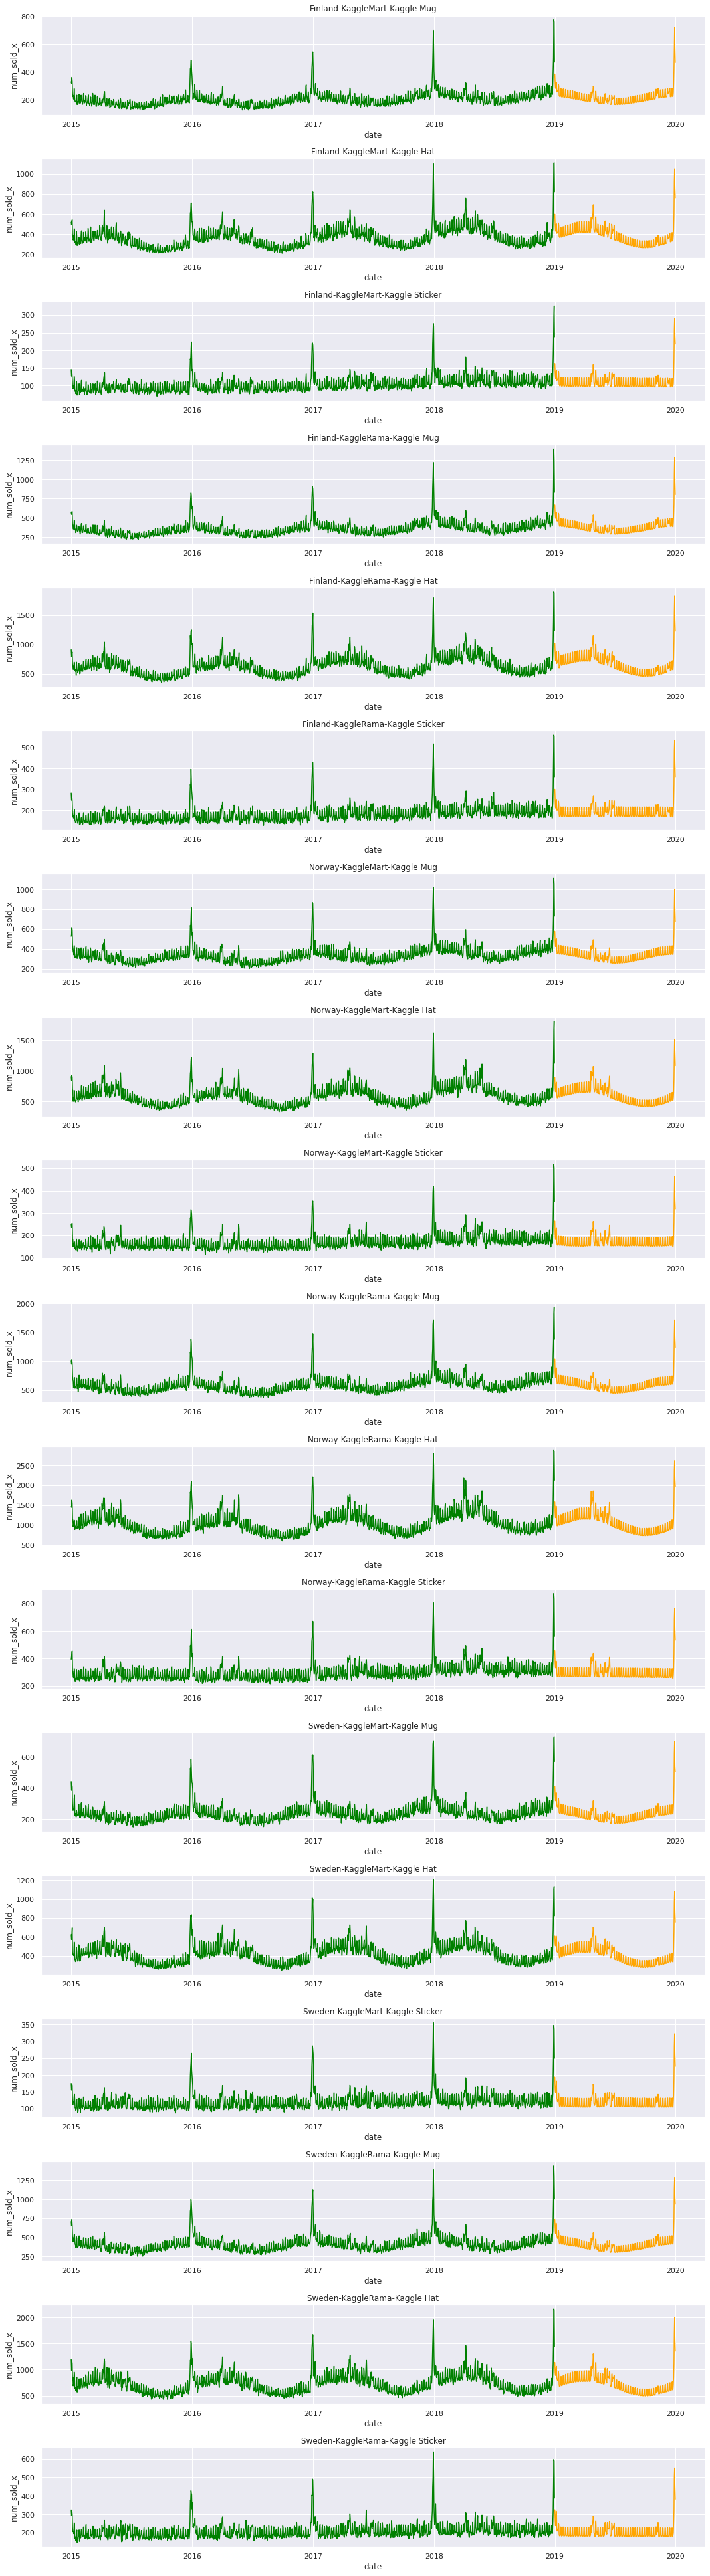

In [71]:
fig, axes = plt.subplots(18, 1, figsize=(15, 18*3))

i = 0
for j in check_df.country.unique():
    for z in check_df.store.unique():
        for w in check_df['product'].unique():
            tmp = check_df.loc[(check_df.country==j) & (check_df.store==z) & (check_df['product']==w),:]
            sns.lineplot(ax=axes[i], x=tmp.index, y=tmp.num_sold_x ,color="green")
            sns.lineplot(ax=axes[i], x=tmp.index, y=tmp.num_sold_y ,color="orange")
            axes[i].set_title(f'{j}-{z}-{w}')
            i += 1
            
fig.tight_layout()

In [72]:
df = df.merge(sub, on='row_id', how='left').fillna(0)
df['num_sold'] = df.num_sold_x + df.num_sold_y

In [73]:
growth_func(df)

country  year  num_sold_grw  gdp_grw  raw_sold_grw
1   Finland  2016         1.042   1.0263        1.0157
2   Finland  2017         1.085   1.0599        1.0241
3   Finland  2018         1.087   1.0806        1.0055
4   Finland  2019         0.959   0.9753        0.9832
6    Norway  2016         0.965   0.9560        1.0091
7    Norway  2017         1.097   1.0802        1.0157
8    Norway  2018         1.101   1.0969        1.0038
9    Norway  2019         0.911   0.9279        0.9817
11   Sweden  2016         1.028   1.0209        1.0072
12   Sweden  2017         1.061   1.0492        1.0109
13   Sweden  2018         1.023   1.0267        0.9963
14   Sweden  2019         0.937   0.9612        0.9754

In [74]:
grw_df = growth_func(df)

<AxesSubplot:xlabel='year', ylabel='num_sold_grw'>

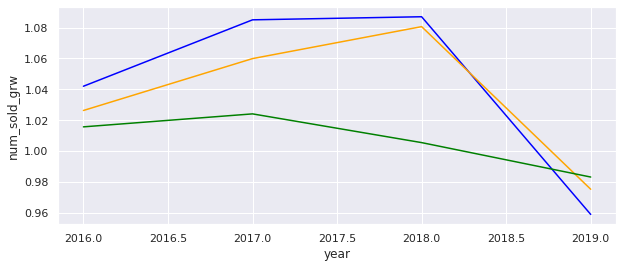

In [75]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(x=grw_df.loc[grw_df.country=="Finland"].year, y=grw_df.loc[grw_df.country=="Finland"].num_sold_grw, color="blue")
sns.lineplot(x=grw_df.loc[grw_df.country=="Finland"].year, y=grw_df.loc[grw_df.country=="Finland"].gdp_grw, color="orange")
sns.lineplot(x=grw_df.loc[grw_df.country=="Finland"].year, y=grw_df.loc[grw_df.country=="Finland"].raw_sold_grw, color="green")

<AxesSubplot:xlabel='year', ylabel='num_sold_grw'>

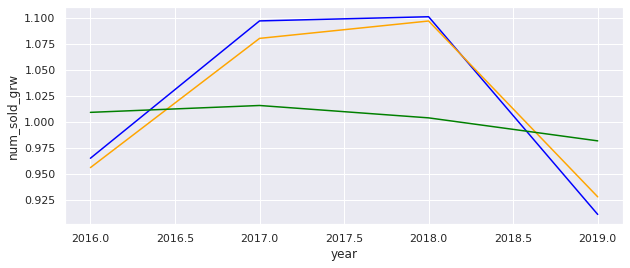

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(x=grw_df.loc[grw_df.country=="Norway"].year, y=grw_df.loc[grw_df.country=="Norway"].num_sold_grw, color="blue")
sns.lineplot(x=grw_df.loc[grw_df.country=="Norway"].year, y=grw_df.loc[grw_df.country=="Norway"].gdp_grw, color="orange")
sns.lineplot(x=grw_df.loc[grw_df.country=="Norway"].year, y=grw_df.loc[grw_df.country=="Norway"].raw_sold_grw, color="green")

<AxesSubplot:xlabel='year', ylabel='num_sold_grw'>

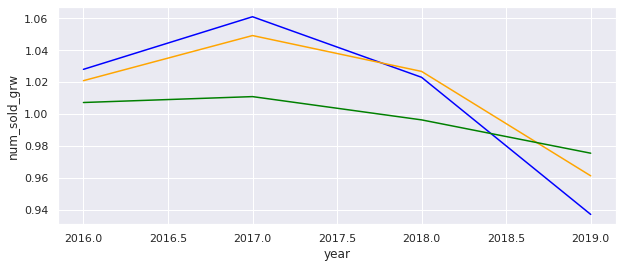

In [77]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(x=grw_df.loc[grw_df.country=="Sweden"].year, y=grw_df.loc[grw_df.country=="Sweden"].num_sold_grw, color="blue")
sns.lineplot(x=grw_df.loc[grw_df.country=="Sweden"].year, y=grw_df.loc[grw_df.country=="Sweden"].gdp_grw, color="orange")
sns.lineplot(x=grw_df.loc[grw_df.country=="Sweden"].year, y=grw_df.loc[grw_df.country=="Sweden"].raw_sold_grw, color="green")

# Final result

In [78]:
sub.sample(10)

row_id  num_sold
597    26895     480.0
1483   27781     817.0
3681   29979     451.0
6371   32669     188.0
664    26962     728.0
2624   28922     131.0
6315   32613     416.0
5945   32243     171.0
4004   30302     193.0
1277   27575     182.0

In [79]:
sub.to_csv('submission.csv', index=False)

# Last notes

- Although MGCV provides many kinds of smooth terms, I only tried some of them. I will glance at the others too. 

- I used by-interaction to manage the event periods. I would like to know if there is a better way to deal with this kind of periods. Trying different kinds of combination, this interaction seemed to allow a better fit. 

- I tried to use gamm instead of gam in order to add correlation term for errors in the model, but I couldn't make it run. I don't know if either it was a problem with rpy2 or I was wrong somewhere.

I will be happy to receive any advice and any error reports to improve my work. Thanks.